In [39]:
import mag2pfsspy
from datetime import datetime,timedelta
from importlib import reload
import os
reload(mag2pfsspy)

<module 'mag2pfsspy' from '/home/samuel_badman/1_RESEARCH/GIT_REPOS/magnetograms2pfsspy/mag2pfsspy.py'>

## mag2pfsspy

This notebook demonstrates functions which can read in several types of magnetograms with their own specific idiosyncracies, format them as input for pfsspy and then produce a pfsspy.Output object from the resulting map. These work with pfsspy v0.4.2 . Updates needed to make `pfsspy.Input` arguments into `sunpy.map.Map` objects.

An example magnetogram for each of the below functions are included in the `./ExampleData` directory. In each case the magnetogram is from 2018/11/06 - the date of the Parker Solar Probe perihelion 1.

A plotting function is also included to visualize the results.

In [20]:
# In all the examples below, I have placed an example magnetogram 
# file in the ./ExampleData directory, which are for Nov-6 2018 only
# Therefore I set the datetime here and don't change it the rest
# of the notebook
dt = datetime(2018,11,6)

### 1 gong2pfsspy

GONG mrzqs maps are available as zipped fits files from an ftp server:
ftp://gong.nso.edu/QR/zqs

GONG mrzqs maps are zero point corrected maps of radial magnetic field. Limited documentation seems to exist but some description of the zero point correction procedure is given [here] (https://gong.nso.edu/science/posters/rclark-jhu_poster.pdf)  

The full path to a given file is :
..........root............/.month./....day..../....filename...
ftp://gong.nso.edu/QR/zqs/YYYYMMDD/mrzqsYYMMDD/mrzqsYYMMDDtHHMMcXXXX_NNN.fits.gz

* YYYYMMDD is a date e.g. 20181106, YYMMDD likewise e.g. 181106
* HHMM is the map timestamp (there's a new map roughly hourly but the timestamps vary from day to day.
* XXXX is the carrington rotation from within the map is evaluated.
* NNN is (I think!) the number of individual magnetograms blended together to make this synoptic map

Note these files are compressed and an unzip will need to happen after download.

The header is missing unit information which causes sunpy.map to break on reading this in. However, astropy.io.fits can read it in, and then after fixing the header:

`
am = fits.open(filepath)[0]
am.header.append(('CUNIT1','degree')) 
am.header.append(('CUNIT2','degree'))  
`

`am` can be passed to sunpy.map.Map. Note, even though GONG mrzqs maps are binned in sinlat vs lon, the sinlat is not a FITS standard unit and so 'CUNIT2' : 'degree' is passed even though technically incorrect.

At present, this map is passed to `extract_br()` which parses the fits header to roll the map so that 0 deg longitude is at the left hand of the map, then subtracts the mean of the magnetogram to roughly remove the monopole offset, and returns the data as a numpy array. It would be straightforward to return as a `sunpy.map.Map`



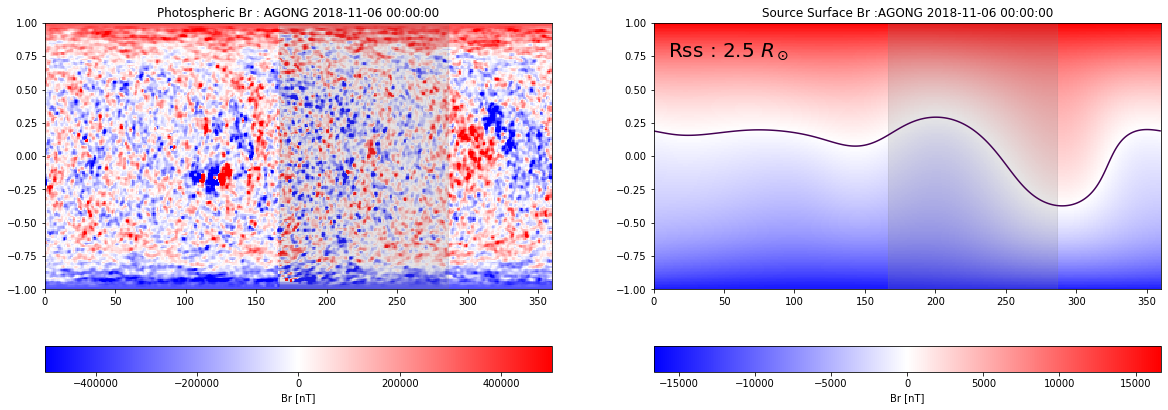

In [19]:
gongOutput = mag2pfsspy.gong2pfsspy(dt,rss=2.5)
_=mag2pfsspy.plot_output(gongOutput)

### 2 adapt2pfsspy

ADAPT maps are also stored as zipped fits files on the GONG ftp server at : ftp://gong.nso.edu/adapt/maps/ 

ADAPT maps (see: https://www.swpc.noaa.gov/sites/default/files/images/u33/SWW_2012_Talk_04_27_2012_Arge.pdf) are assimilative and flux transport modeled magnetograms that attempt to model the whole sun simulaneously, dynamically evolving the regions outside of Earth's fielld of view.

ADAPT maps exist based on both GONG (AGONG: ftp://gong.nso.edu/adapt/maps/gong/ ) and HMI (AHMI: ftp://gong.nso.edu/adapt/maps/special/psp/ )

Note the HMI maps were produced specifically for the Parker Solar Probe perihelia and so currently only exist for approximately +/-1 month of these dates (2018/11/6, 2019/4/4, 2019/9/1, 2020/1/29), with maps given at 8am and 8pm UTC each day

AGONG maps are found at the full path : 

ftp://gong.nso.edu/adapt/maps/gong/YYYY/adapt40311_03i012_201801010000_i00005600n0.fts.gz

and exist for the full time range of GONG observations, 4 times per day.

The file naming convention is explained [here](ftp://gong.nso.edu/adapt/maps/adapt_filename_notes.txt). The most important things to point out are 

Template: 
adapt[ZXABR_CCEFFF]_YYYYMMDDHHNN_[TIIJJKKLLGQ].fts
Example :
adapt[40311_03i012]_201801010000_[i00005600n0].fts
* X Longitude Behaviour : 0 == longitude 0 at LH edge of map
* A Magnetogram source : 3 => GONG, 4 => HMI
* FFF number of realizations : the adapt fits file contains a data cube containing this number of individual 2d magnetograms. These are from different realizations of reconstructing the polar fields.

ADAPT maps are binned in longitude vs latitude. Pfsspy expects uniform binning in sin(lat), so part of `adapt2pfsspy` involves interpolating the data to uniform sinlat  binning.

Additionally, `adapt2pfsspy` takes a keyword argument `realization`. The default value is `'mean'`but can also be an integer from `0` up to `FFF-1` (see filename above). Mean averages the stack of realizations, while integers will pull out a single slice from the stack.

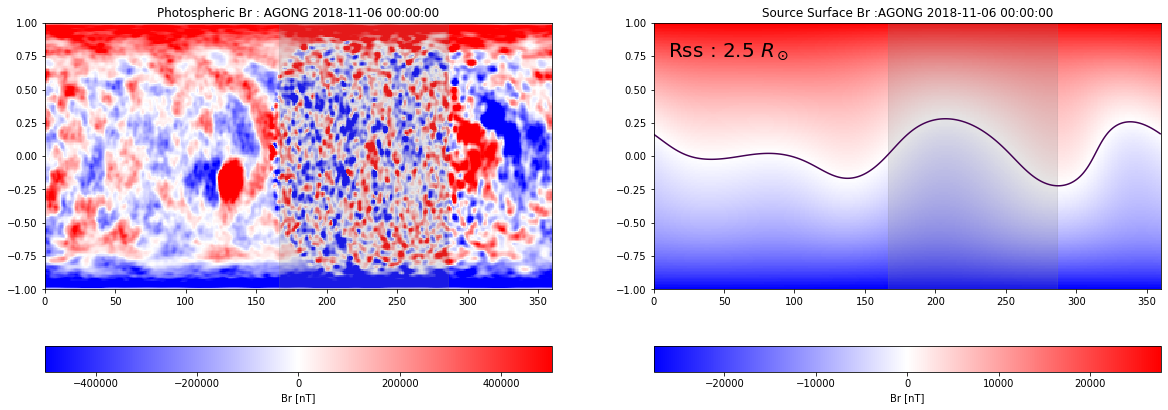

In [27]:
agongOutput = mag2pfsspy.adapt2pfsspy(dt,rss=2.5,adapt_source="GONG")
_=mag2pfsspy.plot_output(agongOutput,adapt_source="GONG")

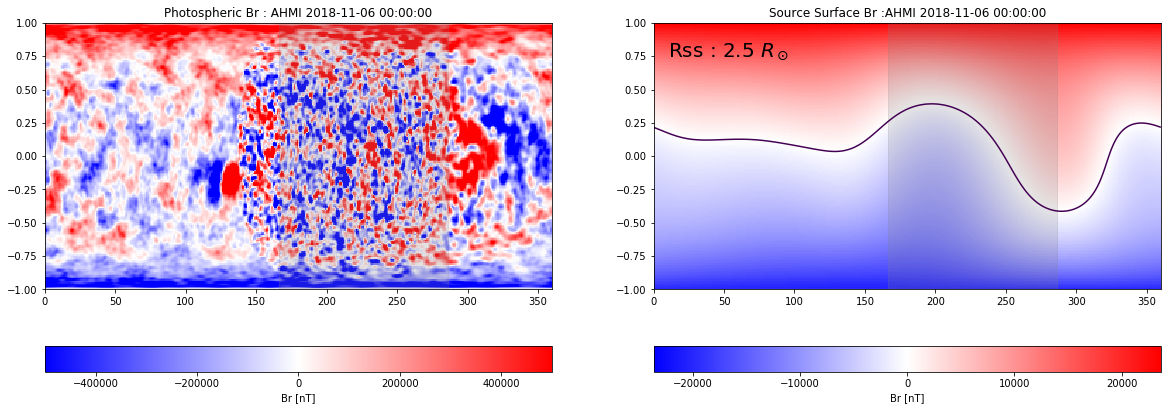

In [30]:
ahmiOutput = mag2pfsspy.adapt2pfsspy(dt,rss=2.5,adapt_source="HMI")
_=mag2pfsspy.plot_output(ahmiOutput,adapt_source="HMI")

### derosa2pfsspy

The LMSAL/DeRosa PFSS solutions are a data product implemented with the intention of being viewed in SolarSoftware IDL. These are a complete PFSS solution generated from a data assimilation and flux transport model similar to ADAPT. The base input for these models are HMI magnetogram observations. Details about the model are given here: https://www.lmsal.com/~derosa/pfsspack/

However, despite the IDL-centric implementation, the files are available as standalone hdf5 files available here :

https://www.lmsal.com/solarsoft/archive/ssw/pfss_links_v2/Bfield_YYYYMMDD_HHMMSS.h5 

There are 4 values per day (YYYYMMDD), always at the same time of day: 

HHMMSS <= 000400, 060432, 120400, 180328

Thus, a http request for a given h5 file can be constructed by specifying YYYYMMDD and choosing HHMMSS from the four options above.

The resulting file is heavy (> 30 MB) and contains the full 3D Br of their PFSS model, with Rss=2.5 Rs. 

`derosa2pfsspy` reads in this full model, pulls out the bottom slice of 3D data cube and uses this as the magnetogram to be inputted into pfsspy. The read in is done with `h5py`, and there are some key values for accessing the resulting data structure that unfortunately have to be hardcoded in. The latitudinal binning, as with adapt, has to be interpolated to uniform in sinlat.

The filepath is generated by looking for the closest time out of 000400, 060432, 120400, 180328 to the datetime specified in the `datetime` argument.

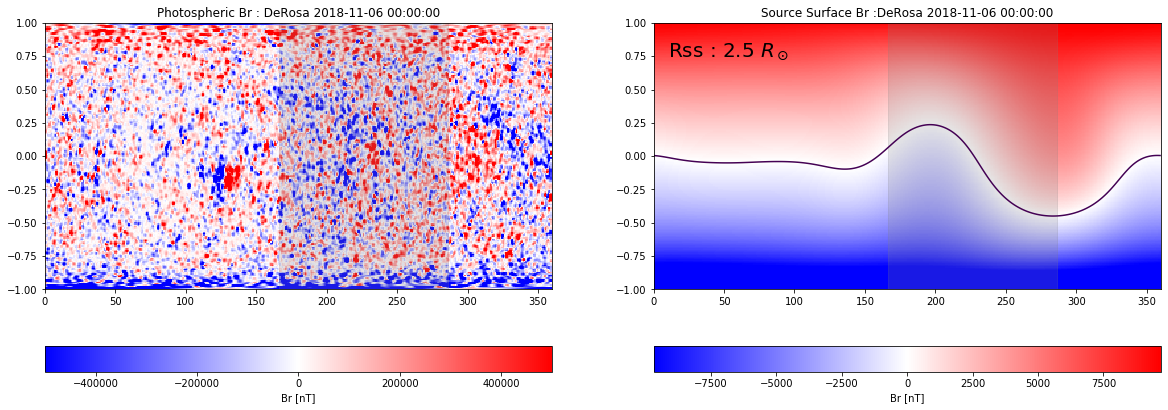

In [47]:
derosaOutput = mag2pfsspy.derosa2pfsspy(dt,rss=2.5)
_=mag2pfsspy.plot_output(derosaOutput,source='DeRosa')

### hmi2pfsspy

Stanford JSOC provides numerous data products for synoptic magnetograms from HMI. Here I use `hmi.mrdailysynframe_small_720s` , 
a daily synoptic map of the radial magnetic field. A full vector inversion is available at the same time cadence at jsoc2 but this is password protected, requiring someone from Stanford to retrieve it for you.

`hmi.mrdailysynframe_small_720s` however, is readily accessible from JSOC and in fact can already be downloaded using the sunpy.net.Fido api. Note, the small keyword, there is higher resolution map, but it is too large for pfsspy to deal with in a practical amount of time.

The resulting fits file is binned correctly in sinlat vs lat. Ad hoc fixes to make the header work were :

* 'CUNIT2' -> 'degree' # Incorrect
* 'HGLN_OBS','CRDER1','CRDER2','CSYSER1','CSYSER2' -> 0 (default was 'nan' but sunpy couldn't parse that.

The other important correction is to note the default frame is stonyhurst, and the reference pixel value must be set to :

`hmi_map.meta['CRVAL1'] = 120 + sun.L0(time=hmi_map.meta['T_OBS']).value` 

This makes the HMI map line up with the others, shifting it to the Carrington frame 

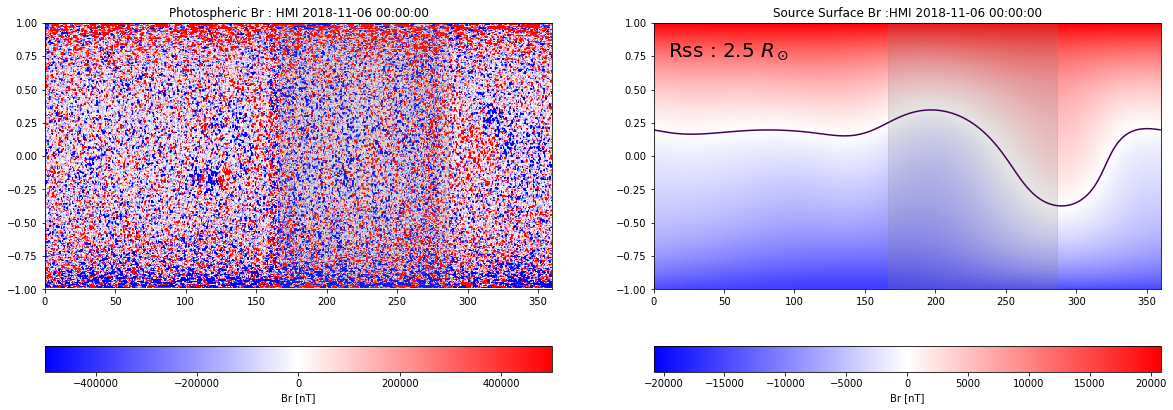

In [49]:
reload(mag2pfsspy)
hmiOutput = mag2pfsspy.hmi2pfsspy(dt,rss=2.5)
_=mag2pfsspy.plot_output(hmiOutput,source="HMI")

### Getting HMI data from the jsoc client :

In [50]:
from sunpy.net import Fido,attrs as a
import drms
res = Fido.search(a.Time('2018-11-06T00:00:00', '2018-11-07T00:00:00'),  
                  a.jsoc.Series('hmi.Mrdailysynframe_small_720s'),  
                  a.jsoc.Notify('samuel_badman@berkeley.edu')
                 )  
downloaded_file = Fido.fetch(res)
downloaded_file

Export request pending. [id="JSOC_20200422_105_X_IN", status=2]
Waiting for 0 seconds...


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00, 10.99file/s]

1 URLs found for download. Full request totalling 1MB


['/home/samuel_badman/sunpy/data/hmi.mrdailysynframe_small_720s.20181106_120000_TAI.data.fits']